<a href="https://colab.research.google.com/github/Leah-Wu/SI650/blob/main/METAPY_BM25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BM25

 install metapy, import and download dataset 

In [8]:
!pip install metapy
import metapy
import pandas as pd
import json
import os
import math
import ast

In [2]:
!wget -nc http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz
!wget -nc http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Electronics.json.gz
!gzip -d reviews_Electronics_5.json.gz
!gzip -d meta_Electronics.json.gz

--2020-12-11 20:47:38--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 495854086 (473M) [application/x-gzip]
Saving to: ‘reviews_Electronics_5.json.gz’

reviews_Electronics 100%[===================>] 472.88M  3.94MB/s    in 90s     

2020-12-11 20:49:08 (5.26 MB/s) - ‘reviews_Electronics_5.json.gz’ saved [495854086/495854086]

--2020-12-11 20:49:08--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Electronics.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 186594679 (178M) [application/x-gzip]
Saving to: ‘meta_Electronics.json.gz’

meta_Electronics.js 100%[===

In [14]:
!wget -nc https://github.com/Leah-Wu/SI650/raw/main/review_data.zip
!wget -nc https://raw.githubusercontent.com/meta-toolkit/meta/master/data/lemur-stopwords.txt
!unzip review_data.zip

--2020-12-11 21:05:44--  https://github.com/Leah-Wu/SI650/raw/main/review_data.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Leah-Wu/SI650/main/review_data.zip [following]
--2020-12-11 21:05:45--  https://raw.githubusercontent.com/Leah-Wu/SI650/main/review_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1865208 (1.8M) [application/zip]
Saving to: ‘review_data.zip’

review_data.zip     100%[===================>]   1.78M  --.-KB/s    in 0.09s   

2020-12-11 21:05:45 (20.2 MB/s) - ‘review_data.zip’ saved [1865208/1865208]

File ‘lemur-stopwords.txt’ already there; not retrieving.

Arc

Build up dataset

In [9]:
def merge_data(reviews_json_file, meta_json_file):
  reviews_Musical_Instruments_5 = pd.read_json(reviews_json_file,lines=True)
  meta_list = []
  with open(meta_json_file) as f:
    for line in f.readlines():
      line = json.dumps(ast.literal_eval(line))
      d = json.loads(line)
      if 'title' not in d:
        continue
      else:
        title = d['title']
        product_id = d['asin']
        img_url = d['imUrl']
    
        meta = []
        
        meta.append(product_id)
        meta.append(title)
        meta.append(img_url)

        meta_list.append(meta)
  column_names = ['asin','title','image_url']
  meta = pd.DataFrame(meta_list, columns=column_names)
  entire_merged_df = reviews_Musical_Instruments_5[['asin','overall','reviewerID','reviewText']].merge(meta[['asin', 'title','image_url']], on='asin', how='inner')
  entire_merged_df['reviewText'] = entire_merged_df['reviewText'].str.lower()
  return entire_merged_df

In [10]:
reviews_json_file = 'reviews_Electronics_5.json'
meta_json_file = 'meta_Electronics.json'
df = merge_data(reviews_json_file, meta_json_file)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1643686 entries, 0 to 1643685
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   asin        1643686 non-null  object
 1   overall     1643686 non-null  int64 
 2   reviewerID  1643686 non-null  object
 3   reviewText  1643686 non-null  object
 4   title       1643686 non-null  object
 5   image_url   1643686 non-null  object
dtypes: int64(1), object(5)
memory usage: 87.8+ MB


Set up configuration file for metapy ranking

In [15]:
def get_dat_file(df):
    data = df['reviewText']
    data.to_csv('review_data/review_data.dat', index=False)

In [16]:
asin_review_df = df[['asin','reviewText']]
get_dat_file(df)

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
with open('review_data/tutorial.toml', 'w') as f:
    f.write('type = "line-corpus"\n')
    f.write('store-full-text = true\n')

config = """prefix = "." # tells MeTA where to search for datasets

dataset = "review_data" # a subfolder under the prefix directory
corpus = "tutorial.toml" # a configuration file for the corpus specifying its format & additional args

index = "review-idx" # subfolder of the current working directory to place index files

query-judgements = "review_data/test-qrels.txt" # file containing the relevance judgments for this dataset

stop-words = "lemur-stopwords.txt"

[[analyzers]]
method = "ngram-word"
ngram = 1
filter = "default-unigram-chain"
"""
with open('review-config.toml', 'w') as f:
    f.write(config)

 Build the inverted index with metapy and get reviews with similarities sort

In [19]:
inv_idx = metapy.index.make_inverted_index('review-config.toml') 

In [24]:
#Original Okapi BM25 performance
ranker = metapy.index.OkapiBM25(k1 = 1.2, b = 0.75, k3 = 500)
count = len(open('review_data/review_data.dat').readlines( ))
num_results = count
retrieval_results = []
query_list = []
with open('review_data/test-queries.txt') as query_file:
    for query_num, line in enumerate(query_file):
        query = metapy.index.Document()
        query.content(line.strip())
        query_list.append((query_num + 1, query.content()))
        results = ranker.score(inv_idx, query, num_results)  
        res_list = [(query_num + 1, x[0]) for x in results]
        retrieval_results += res_list

In [26]:
query_df = pd.DataFrame(query_list, columns=["queryid", "query_text"])
query_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   queryid     20 non-null     int64 
 1   query_text  20 non-null     object
dtypes: int64(1), object(1)
memory usage: 448.0+ bytes


In [21]:
data = pd.DataFrame(retrieval_results, columns=["queryid", "docid"])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5518019 entries, 0 to 5518018
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   queryid  int64
 1   docid    int64
dtypes: int64(2)
memory usage: 84.2 MB


Convert retrieved products to result csv which can be easy to annotate

In [27]:
merged_data = df
num = len(open('review_data/test-queries.txt').readlines( ))
res_list=[]
for q_id in range(num):
  q_id += 1
  doc_id_df = data[data['queryid'] == q_id]
  d_list = doc_id_df['docid'].tolist()
  product_list = []
  for loc in d_list:
    pd_id = merged_data.iloc[int(loc)]['asin']
    if pd_id in product_list: continue
    product_list.append(pd_id)
    url="https://www.amazon.com/dp/"+str(pd_id)
    res_list.append((q_id, pd_id, url))
    if len(product_list) == 10: 
      break 

res_df = pd.DataFrame(res_list, columns=["queryid","productid","product_url"])
res_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   queryid      200 non-null    int64 
 1   productid    200 non-null    object
 2   product_url  200 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.8+ KB


In [28]:
res_with_reviewText_df = res_df[["queryid","productid","product_url"]].merge(query_df[["queryid", "query_text"]], on='queryid', how='inner')
res_with_reviewText_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   queryid      200 non-null    int64 
 1   productid    200 non-null    object
 2   product_url  200 non-null    object
 3   query_text   200 non-null    object
dtypes: int64(1), object(3)
memory usage: 7.8+ KB


In [29]:
res_with_reviewText_df.to_csv("bm25-results.csv")

polarity of dataset:

In [32]:
pip install textblob

In [33]:
from textblob import TextBlob

In [34]:
pol = lambda x: TextBlob(x).sentiment.polarity
df['polarity'] = df['reviewText'].apply(pol)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1643686 entries, 0 to 1643685
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   asin        1643686 non-null  object 
 1   overall     1643686 non-null  int64  
 2   reviewerID  1643686 non-null  object 
 3   reviewText  1643686 non-null  object 
 4   title       1643686 non-null  object 
 5   image_url   1643686 non-null  object 
 6   polarity    1643686 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 100.3+ MB


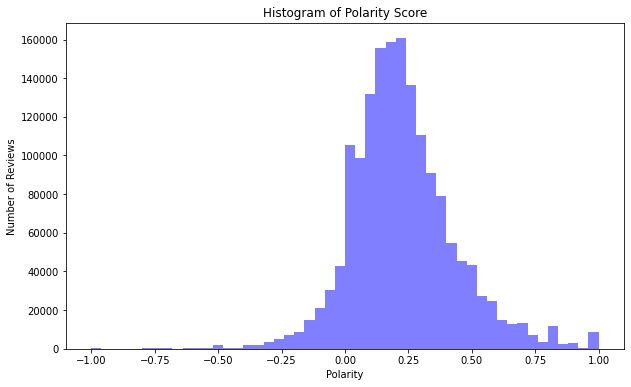

In [36]:
import matplotlib.pyplot as plt

num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df.polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Number of Reviews')
plt.title('Histogram of Polarity Score')
plt.show();

After annotation, evaluation is in evaluation.ipynb

